## Mini Project 5
### Team Members: Michael Persson & Ledja Halltari 

In [85]:
# ============================================================
# SETUP — Run this first!
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import os
import random

# Verify versions
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version:      {np.__version__}")

# Check GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\n✅ GPU available: {gpus[0].name}")
else:
    print("\n⚠️  No GPU detected. Go to Runtime → Change runtime type → T4 GPU")

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

TensorFlow version: 2.20.0
NumPy version:      2.2.6

⚠️  No GPU detected. Go to Runtime → Change runtime type → T4 GPU
Num GPUs Available:  0


In [86]:
import kagglehub

dataset_path = kagglehub.dataset_download("mahmoudreda55/satellite-image-classification")
print(f"Dataset downloaded to: {dataset_path}")

# Print structure to understand folder layout
print("\nDataset structure:")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = '  ' * level
    print(f"{indent}{os.path.basename(root)}/  ({len(files)} files)")
    if level >= 3:
        continue


Dataset downloaded to: /Users/ledjahalltari/.cache/kagglehub/datasets/mahmoudreda55/satellite-image-classification/versions/1

Dataset structure:
1/  (0 files)
  data/  (0 files)
    cloudy/  (1500 files)
    water/  (1500 files)
    green_area/  (1500 files)
    desert/  (1092 files)


## Data Exploration & Preprocessing

In [87]:
import hashlib

def file_hash(path, chunk_size=8192):
    hasher = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            hasher.update(chunk)
    return hasher.hexdigest()

seen = {}
duplicates = []

for root_dir, _, file_list in os.walk(dataset_path):
    for fname in file_list:
        if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        fpath = os.path.join(root_dir, fname)
        h = file_hash(fpath)
        if h in seen:
            duplicates.append(fpath)
        else:
            seen[h] = fpath

for dup in duplicates:
    os.remove(dup)

print(f"Total images scanned: {len(seen) + len(duplicates)}")
print(f"Duplicates removed: {len(duplicates)}")
print(f"Unique images remaining: {len(seen)}")

Total images scanned: 5592
Duplicates removed: 0
Unique images remaining: 5592


In [88]:
data_dir = os.path.join(dataset_path, "data")

batch_size = 64
img_size = (64, 64)
seed = 42

full_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
)
class_names = full_ds.class_names
print("Class names:", class_names)

# Inspect a single batch
for images, labels in full_ds.take(1):
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)

# Class distribution in full_ds
num_classes = len(class_names)
class_counts = np.zeros(num_classes, dtype=int)

for _, labels in full_ds:
    class_counts += np.bincount(labels.numpy(), minlength=num_classes)

for name, count in zip(class_names, class_counts):
    print(f"{name}: {count}")

full_ds = full_ds.shuffle(1000, seed=seed, reshuffle_each_iteration=False)

total_batches = tf.data.experimental.cardinality(full_ds).numpy()
test_batches = max(1, total_batches // 10)
val_batches = max(1, total_batches // 10)

test_ds = full_ds.take(test_batches)
val_ds = full_ds.skip(test_batches).take(val_batches)
train_ds = full_ds.skip(test_batches + val_batches)

print(f"Train batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Val batches:   {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Test batches:  {tf.data.experimental.cardinality(test_ds).numpy()}")

Found 5592 files belonging to 4 classes.
Class names: ['cloudy', 'desert', 'green_area', 'water']
Images batch shape: (64, 64, 64, 3)
Labels batch shape: (64,)
cloudy: 1500
desert: 1092
green_area: 1500
water: 1500
Train batches: 72
Val batches:   8
Test batches:  8


## EDA


Images batch shape: (64, 64, 64, 3)
Labels batch shape: (64,)
cloudy: 1234
desert: 897
green_area: 1203
water: 1234


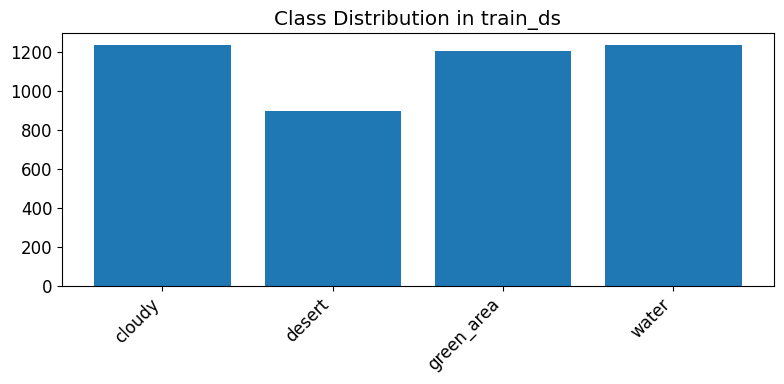

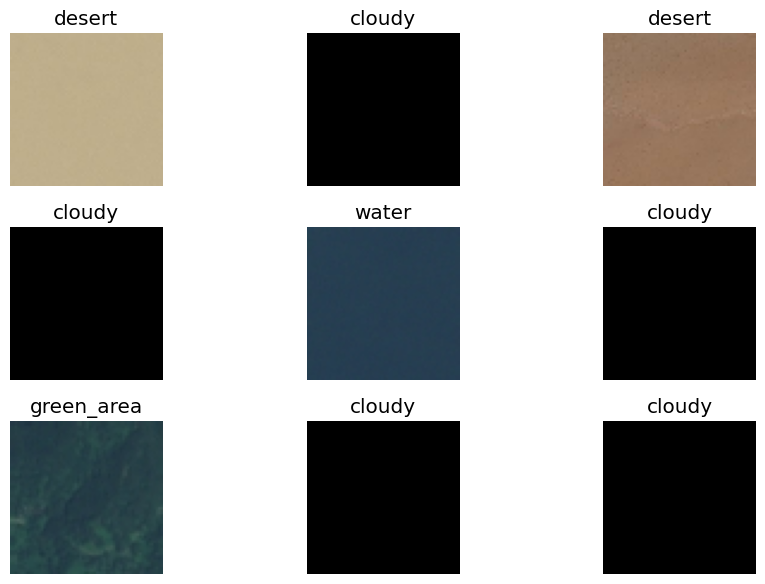

In [89]:
# Basic EDA on train_ds: batch shapes and class distribution


# Inspect a single batch
for images, labels in train_ds.take(1):
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)

# Class distribution in train_ds
num_classes = len(class_names)
class_counts = np.zeros(num_classes, dtype=int)

for _, labels in train_ds:
    class_counts += np.bincount(labels.numpy(), minlength=num_classes)

for name, count in zip(class_names, class_counts):
    print(f"{name}: {count}")

# Plot class distribution
plt.figure(figsize=(8, 4))
plt.bar(class_names, class_counts)
plt.title("Class Distribution in train_ds")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Visualize a few sample images
plt.figure(figsize=(10, 6))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()

In [90]:
# Optimize data pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
print("✅ Data pipeline optimized")

✅ Data pipeline optimized


## Basic CNN Model


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,716 (2.61 MB)

 Trainable params: 683,716 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.7410 - loss: 0.8004 - val_accuracy: 0.8711 - val_loss: 0.2889
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8498 - loss: 0.3076 - val_accuracy: 0.8555 - val_loss: 0.3339
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8960 - loss: 0.2444 - val_accuracy: 0.8828 - val_loss: 0.2590
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9122 - loss: 0.2129 - val_accuracy: 0.8965 - val_loss: 0.2272
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9129 - loss: 0.1988 - val_accuracy: 0.9160 - val_loss: 0.1688
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9299 - loss: 0.1704 - val_accuracy: 0.9160 - val_loss: 0.1809
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9275 - loss: 0.1647 - val_accuracy: 0.9395 - val_loss: 0.1492
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9494 - loss: 0.1229 - val_accuracy: 0.9648 - v

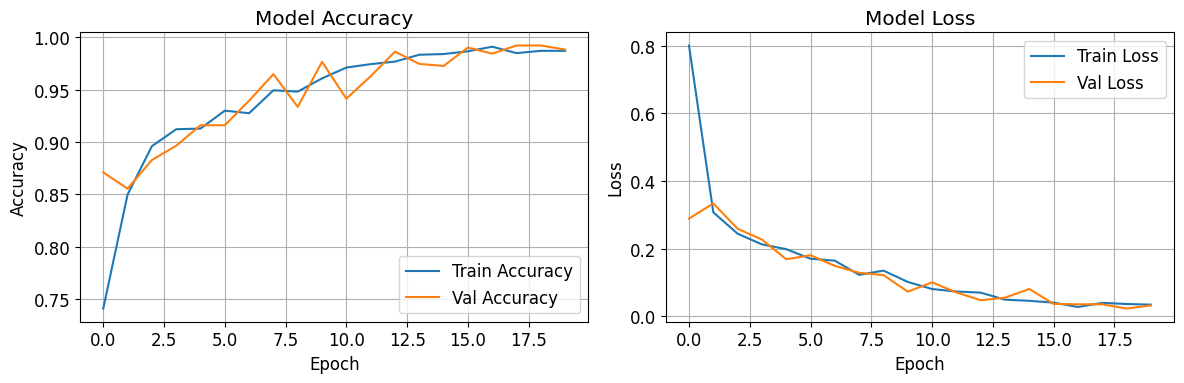

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9902 - loss: 0.0273

Test Accuracy: 0.9902
Test Loss: 0.0273


In [91]:
# Build CNN model
model_basic = models.Sequential([
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    # layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model_basic.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model_basic.summary()

# Train the model
history_basic = model_basic.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_basic.history['accuracy'], label='Train Accuracy')
plt.plot(history_basic.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_basic.history['loss'], label='Train Loss')
plt.plot(history_basic.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate on test set
test_loss, test_accuracy = model_basic.evaluate(test_ds)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

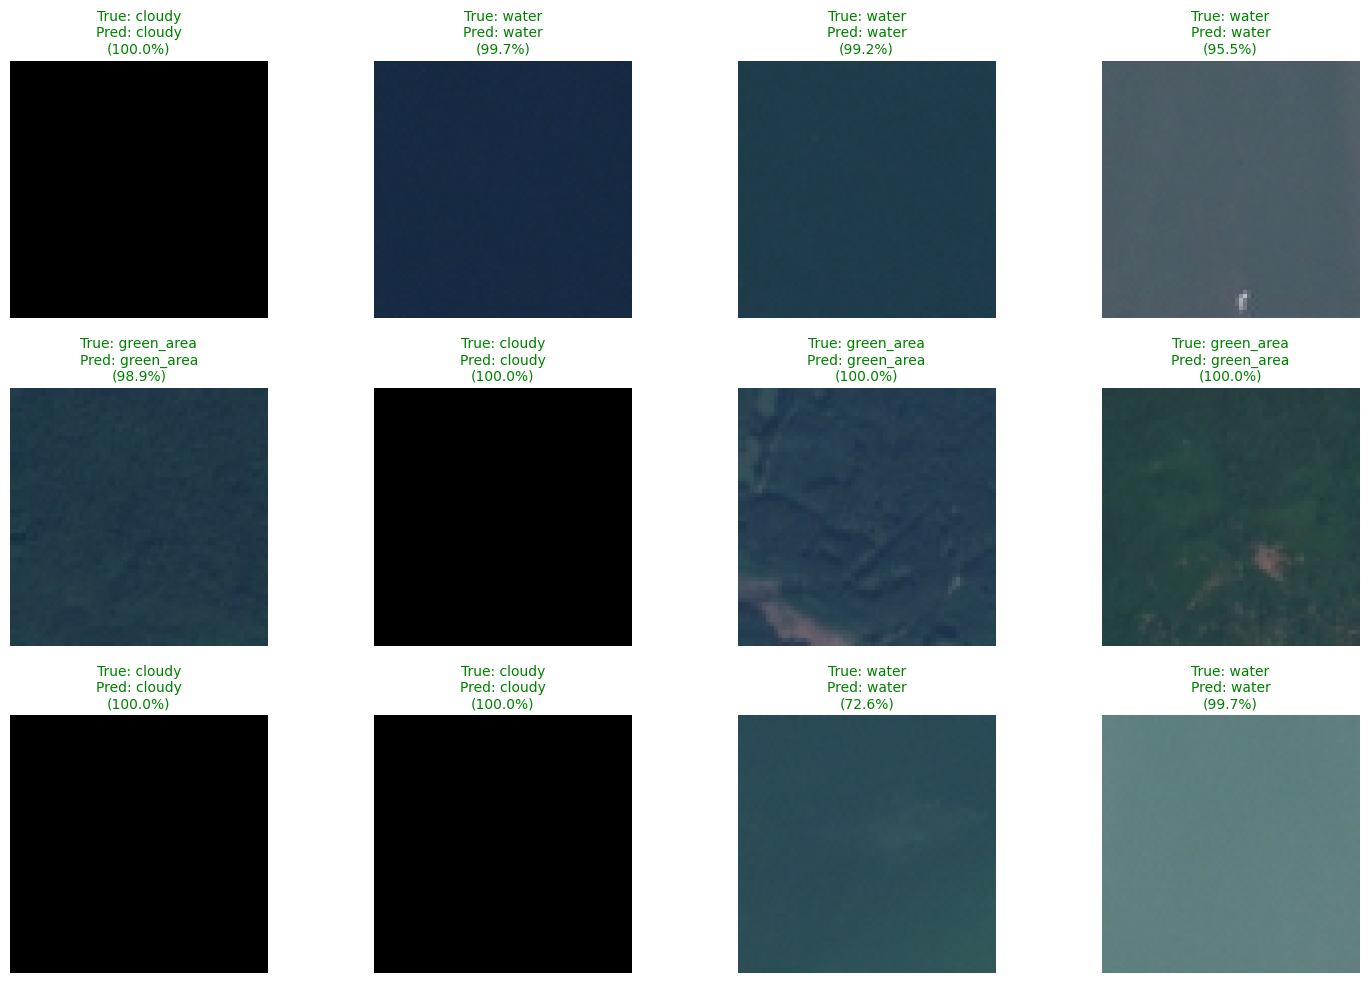

In [92]:
# Get predictions on test set
plt.figure(figsize=(15, 10))

# Get one batch from test set
for images_batch, labels_batch in test_ds.take(1):
    predictions = model_basic.predict(images_batch, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Display 12 images
    for i in range(min(12, len(images_batch))):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        
        true_label = class_names[labels_batch[i]]
        pred_label = class_names[predicted_classes[i]]
        confidence = predictions[i][predicted_classes[i]] * 100
        
        # Color: green if correct, red if incorrect
        color = 'green' if labels_batch[i] == predicted_classes[i] else 'red'
        
        plt.title(f"True: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)", 
                  color=color, fontsize=10)
        plt.axis("off")

plt.tight_layout()
plt.show()

## Augmented CNN Model

/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/preprocessing/data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_12 (Rescaling)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_12 (RandomFlip)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_12              │ (None, 64, 64, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_12 (RandomZoom)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,612 (2.61 MB)

 Trainable params: 684,164 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.8796 - loss: 0.3791 - val_accuracy: 0.2988 - val_loss: 3.7940
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.9151 - loss: 0.1823 - val_accuracy: 0.2910 - val_loss: 5.8727
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.9205 - loss: 0.2054 - val_accuracy: 0.3398 - val_loss: 7.9806
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9175 - loss: 0.2145 - val_accuracy: 0.3867 - val_loss: 7.0492
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.9247 - loss: 0.1647 - val_accuracy: 0.7188 - val_loss: 0.9178
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9343 - loss: 0.1539 - val_accuracy: 0.8125 - val_loss: 0.4600
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9490 - loss: 0.1295 - val_accuracy: 0.7129 - val_loss: 0.7130
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9558 - loss: 0.1083 - val_accuracy: 0.8477 - v

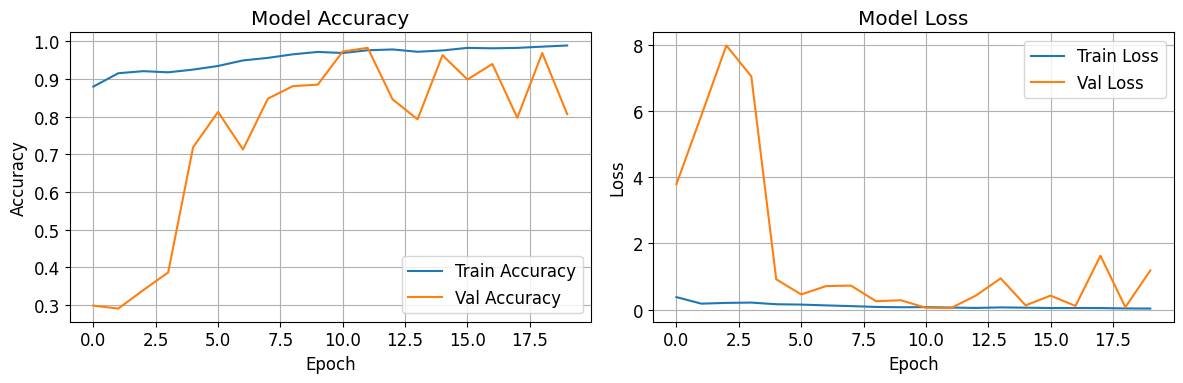

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8418 - loss: 1.0628

Test Accuracy: 0.8418
Test Loss: 1.0628


In [93]:
# Build CNN model
model_augmented = models.Sequential([

    layers.Rescaling(1./255, input_shape=(64, 64, 3)),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten and dense layers
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model_augmented.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model_augmented.summary()

# Train the model
history_augmented = model_augmented.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_augmented.history['accuracy'], label='Train Accuracy')
plt.plot(history_augmented.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_augmented.history['loss'], label='Train Loss')
plt.plot(history_augmented.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate on test set
test_loss, test_accuracy = model_augmented.evaluate(test_ds)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

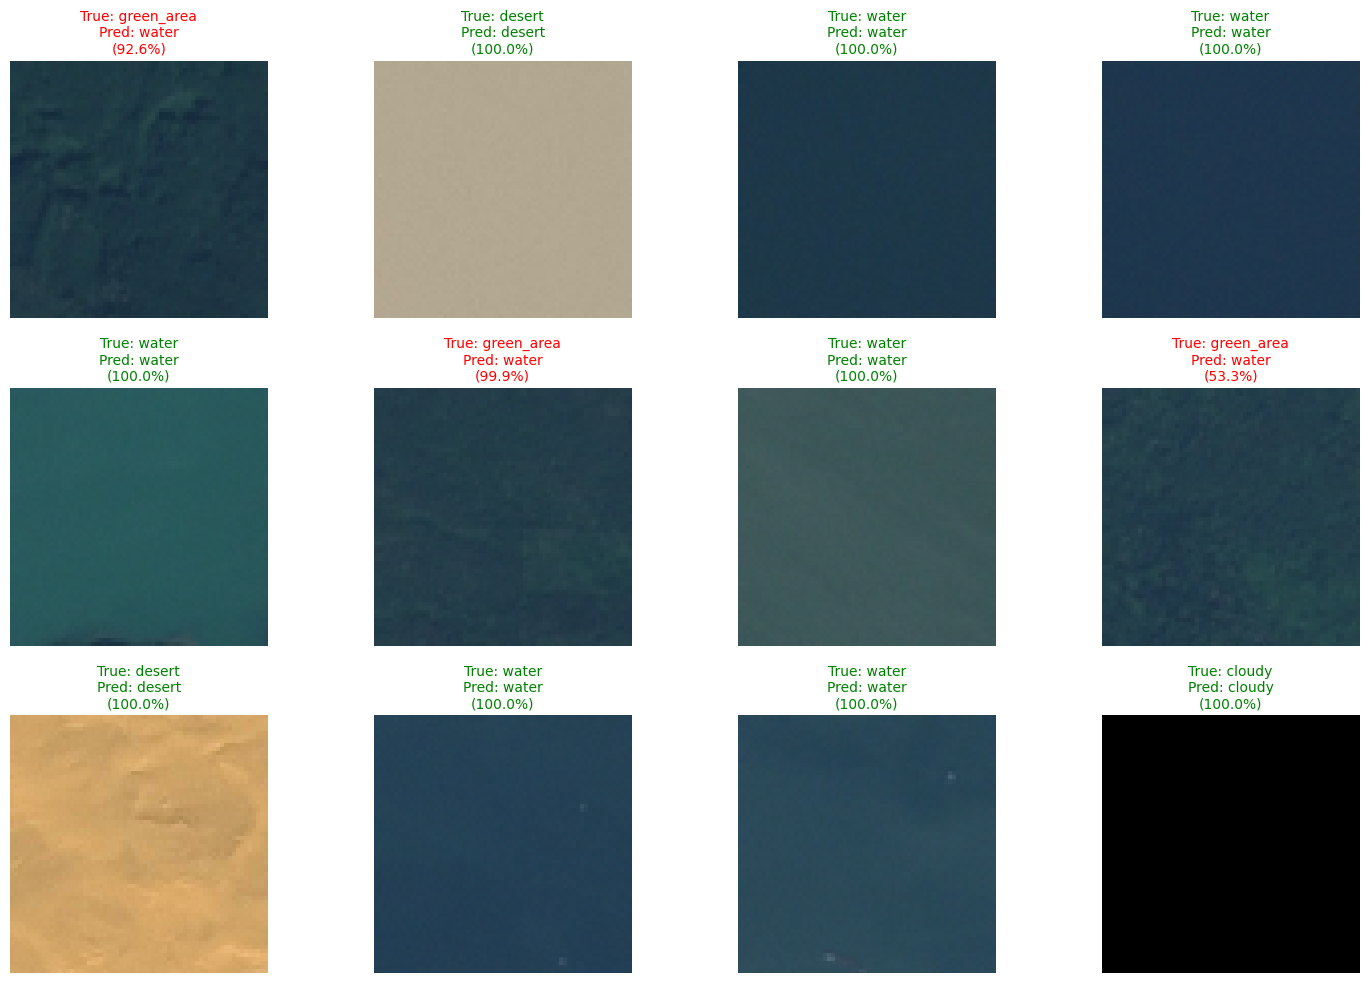

In [94]:
# Get predictions on test set
plt.figure(figsize=(15, 10))

# Get one batch from test set
for images_batch, labels_batch in test_ds.take(1):
    predictions = model_augmented.predict(images_batch, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Display 12 images
    for i in range(min(12, len(images_batch))):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        
        true_label = class_names[labels_batch[i]]
        pred_label = class_names[predicted_classes[i]]
        confidence = predictions[i][predicted_classes[i]] * 100
        
        # Color: green if correct, red if incorrect
        color = 'green' if labels_batch[i] == predicted_classes[i] else 'red'
        
        plt.title(f"True: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)", 
                  color=color, fontsize=10)
        plt.axis("off")

plt.tight_layout()
plt.show()

## Experimental CNN model


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_13 (Rescaling)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_13 (RandomFlip)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_13              │ (None, 64, 64, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_13 (RandomZoom)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 26, 26, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,212 (258.64 KB)

 Trainable params: 66,020 (257.89 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.8816 - loss: 0.2965 - val_accuracy: 0.5547 - val_loss: 1.0881
Epoch 2/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.9146 - loss: 0.1987 - val_accuracy: 0.6016 - val_loss: 0.9056
Epoch 3/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.9284 - loss: 0.1752 - val_accuracy: 0.6367 - val_loss: 0.8307
Epoch 4/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.9315 - loss: 0.1603 - val_accuracy: 0.7559 - val_loss: 0.5670
Epoch 5/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.9440 - loss: 0.1388 - val_accuracy: 0.8066 - val_loss: 0.4331
Epoch 6/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.9567 - loss: 0.1061 - val_accuracy: 0.8887 - val_loss: 0.2553
Epoch 7/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.9674 - loss: 0.0868 - val_accuracy: 0.8633 - val_loss: 0.2878
Epoch 8/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.9803 - loss: 0.0576 - val_accuracy: 0.

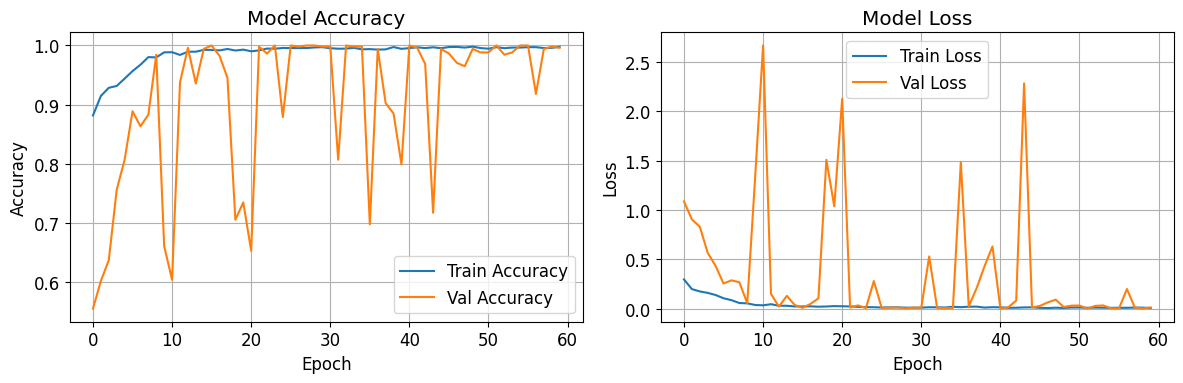

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9902 - loss: 0.0387

Test Accuracy: 0.9902
Test Loss: 0.0387


In [95]:
# Build CNN model
model_experimental = models.Sequential([

    layers.Rescaling(1./255, input_shape=(64, 64, 3)),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),

    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu'),
    # layers.BatchNormalization(),
    # layers.MaxPooling2D((2, 2)),
    
    # Second convolutional block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Third convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.BatchNormalization(),
    # layers.MaxPooling2D((2, 2)),

    # Fourth convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    
    # Flatten and dense layers
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    # layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model_experimental.compile(
    optimizer='adamw',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model_experimental.summary()

# Train the model
history_experimental = model_experimental.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_experimental.history['accuracy'], label='Train Accuracy')
plt.plot(history_experimental.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_experimental.history['loss'], label='Train Loss')
plt.plot(history_experimental.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate on test set
test_loss, test_accuracy = model_experimental.evaluate(test_ds)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

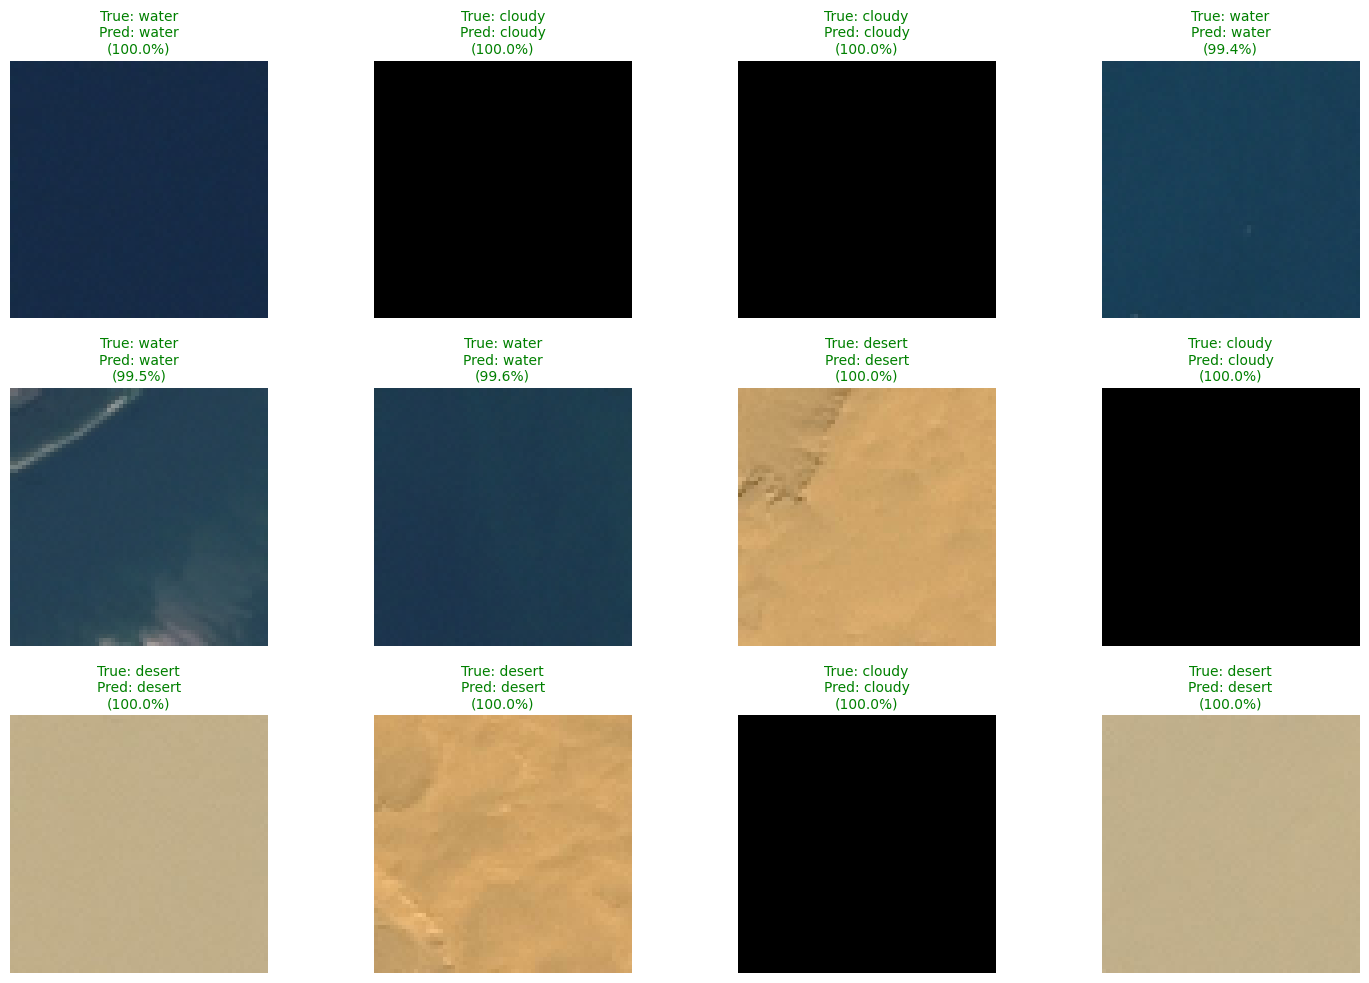

In [96]:
# Get predictions on test set
plt.figure(figsize=(15, 10))

# Get one batch from test set
for images_batch, labels_batch in test_ds.take(1):
    predictions = model_experimental.predict(images_batch, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Display 12 images
    for i in range(min(12, len(images_batch))):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        
        true_label = class_names[labels_batch[i]]
        pred_label = class_names[predicted_classes[i]]
        confidence = predictions[i][predicted_classes[i]] * 100
        
        # Color: green if correct, red if incorrect
        color = 'green' if labels_batch[i] == predicted_classes[i] else 'red'
        
        plt.title(f"True: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)", 
                  color=color, fontsize=10)
        plt.axis("off")

plt.tight_layout()
plt.show()

## Comparison between augmented model to baseline model


📊 Model Comparison Summary:
                      Model  Train Accuracy  Val Accuracy  Train Loss  Val Loss
     Baseline (model_basic)        0.987084      0.988281    0.034817  0.032660
Augmented (model_augmented)        0.988616      0.806641    0.033789  1.184817

🎯 Test Set Performance:
Baseline Model     - Accuracy: 0.9902, Loss: 0.0304
Augmented Model    - Accuracy: 0.8281, Loss: 1.0311
Improvement        - Accuracy: -0.1621


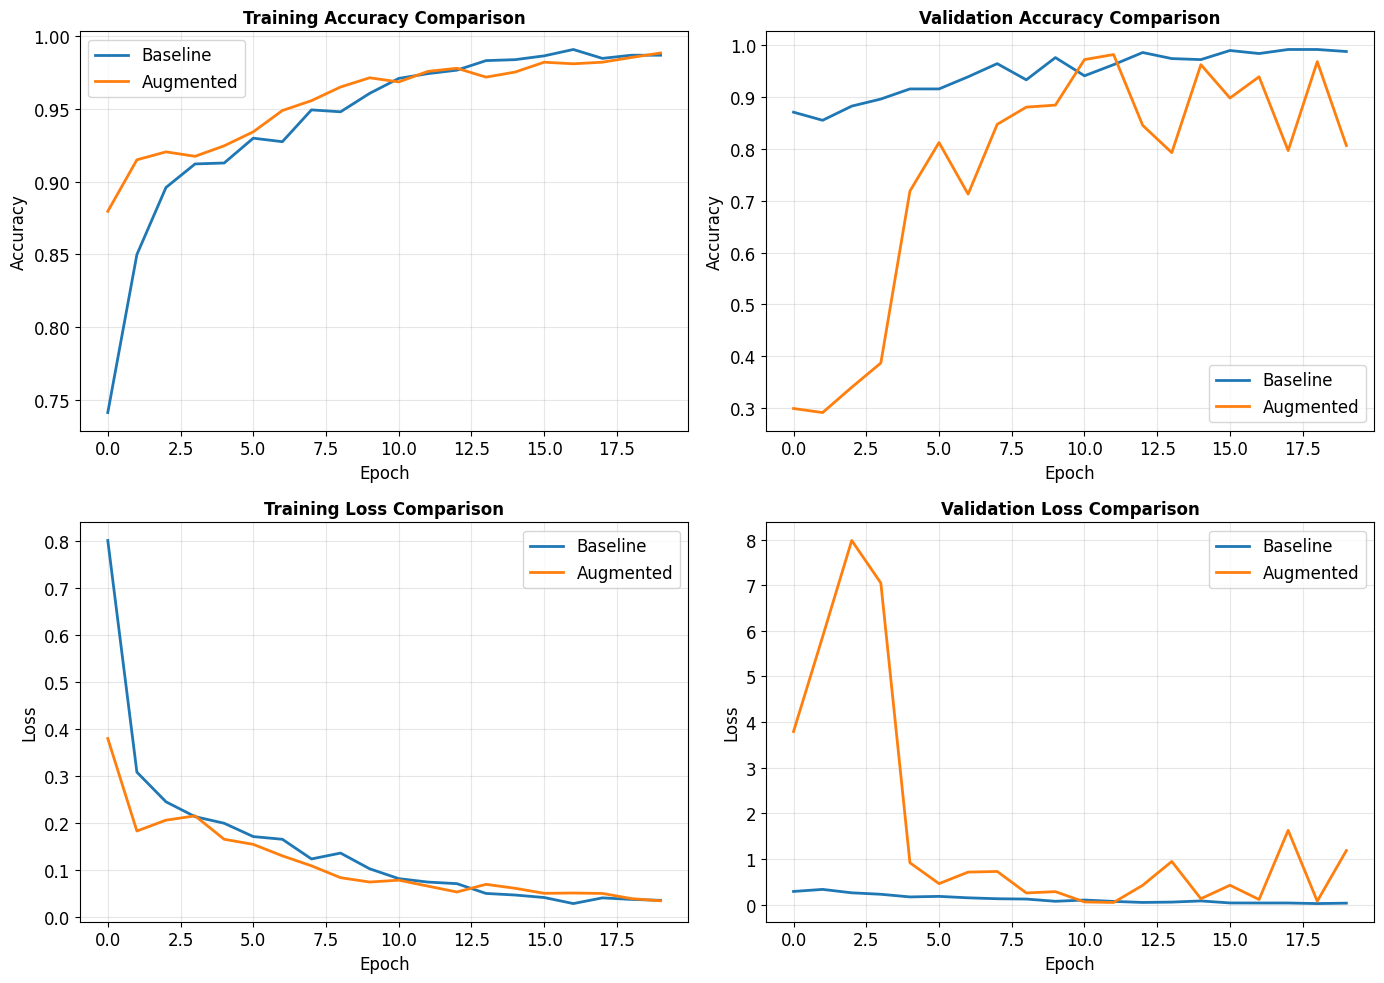

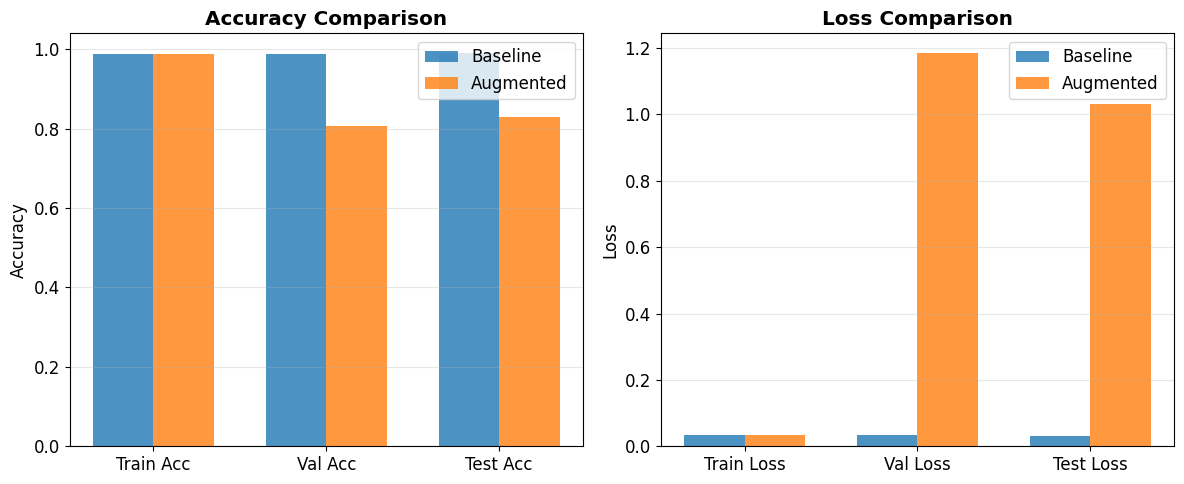

In [97]:
import pandas as pd

# Compare augmented model to baseline model

# Create comparison dataframe
comparison_data = {
    'Model': ['Baseline (model_basic)', 'Augmented (model_augmented)'],
    'Train Accuracy': [
        history_basic.history['accuracy'][-1],
        history_augmented.history['accuracy'][-1]
    ],
    'Val Accuracy': [
        history_basic.history['val_accuracy'][-1],
        history_augmented.history['val_accuracy'][-1]
    ],
    'Train Loss': [
        history_basic.history['loss'][-1],
        history_augmented.history['loss'][-1]
    ],
    'Val Loss': [
        history_basic.history['val_loss'][-1],
        history_augmented.history['val_loss'][-1]
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n📊 Model Comparison Summary:")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Evaluate both models on test set
test_loss_basic, test_acc_basic = model_basic.evaluate(test_ds, verbose=0)
test_loss_aug, test_acc_aug = model_augmented.evaluate(test_ds, verbose=0)

print(f"\n🎯 Test Set Performance:")
print(f"Baseline Model     - Accuracy: {test_acc_basic:.4f}, Loss: {test_loss_basic:.4f}")
print(f"Augmented Model    - Accuracy: {test_acc_aug:.4f}, Loss: {test_loss_aug:.4f}")
print(f"Improvement        - Accuracy: {(test_acc_aug - test_acc_basic):.4f}")

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Training accuracy comparison
axes[0, 0].plot(history_basic.history['accuracy'], label='Baseline', linewidth=2)
axes[0, 0].plot(history_augmented.history['accuracy'], label='Augmented', linewidth=2)
axes[0, 0].set_title('Training Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Validation accuracy comparison
axes[0, 1].plot(history_basic.history['val_accuracy'], label='Baseline', linewidth=2)
axes[0, 1].plot(history_augmented.history['val_accuracy'], label='Augmented', linewidth=2)
axes[0, 1].set_title('Validation Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Training loss comparison
axes[1, 0].plot(history_basic.history['loss'], label='Baseline', linewidth=2)
axes[1, 0].plot(history_augmented.history['loss'], label='Augmented', linewidth=2)
axes[1, 0].set_title('Training Loss Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Validation loss comparison
axes[1, 1].plot(history_basic.history['val_loss'], label='Baseline', linewidth=2)
axes[1, 1].plot(history_augmented.history['val_loss'], label='Augmented', linewidth=2)
axes[1, 1].set_title('Validation Loss Comparison', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Bar chart for final metrics
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

metrics = ['Train Acc', 'Val Acc', 'Test Acc']
baseline_scores = [
    history_basic.history['accuracy'][-1],
    history_basic.history['val_accuracy'][-1],
    test_acc_basic
]
augmented_scores = [
    history_augmented.history['accuracy'][-1],
    history_augmented.history['val_accuracy'][-1],
    test_acc_aug
]

x = np.arange(len(metrics))
width = 0.35

ax[0].bar(x - width/2, baseline_scores, width, label='Baseline', alpha=0.8)
ax[0].bar(x + width/2, augmented_scores, width, label='Augmented', alpha=0.8)
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy Comparison', fontweight='bold')
ax[0].set_xticks(x)
ax[0].set_xticklabels(metrics)
ax[0].legend()
ax[0].grid(True, alpha=0.3, axis='y')

loss_metrics = ['Train Loss', 'Val Loss', 'Test Loss']
baseline_losses = [
    history_basic.history['loss'][-1],
    history_basic.history['val_loss'][-1],
    test_loss_basic
]
augmented_losses = [
    history_augmented.history['loss'][-1],
    history_augmented.history['val_loss'][-1],
    test_loss_aug
]

ax[1].bar(x - width/2, baseline_losses, width, label='Baseline', alpha=0.8)
ax[1].bar(x + width/2, augmented_losses, width, label='Augmented', alpha=0.8)
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss Comparison', fontweight='bold')
ax[1].set_xticks(x)
ax[1].set_xticklabels(loss_metrics)
ax[1].legend()
ax[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [98]:
from sklearn.metrics import f1_score, classification_report
import numpy as np

# Create detailed comparison table with additional metrics


# Get predictions for both models on test set
test_predictions_basic = []
test_labels_list = []
test_predictions_aug = []
test_predictions_exp = []

for images, labels in test_ds:
    pred_basic = model_basic.predict(images, verbose=0)
    pred_aug = model_augmented.predict(images, verbose=0)
    pred_exp = model_experimental.predict(images, verbose=0)
    test_predictions_basic.extend(np.argmax(pred_basic, axis=1))
    test_predictions_aug.extend(np.argmax(pred_aug, axis=1))
    test_predictions_exp.extend(np.argmax(pred_exp, axis=1))
    test_labels_list.extend(labels.numpy())

test_predictions_basic = np.array(test_predictions_basic)
test_predictions_aug = np.array(test_predictions_aug)
test_predictions_exp = np.array(test_predictions_exp)
test_labels_list = np.array(test_labels_list)

# Calculate F1 scores
f1_basic = f1_score(test_labels_list, test_predictions_basic, average='weighted')
f1_aug = f1_score(test_labels_list, test_predictions_aug, average='weighted')
f1_exp = f1_score(test_labels_list, test_predictions_exp, average='weighted')

# Calculate train-val gaps
train_val_gap_basic = history_basic.history['accuracy'][-1] - history_basic.history['val_accuracy'][-1]
train_val_gap_aug = history_augmented.history['accuracy'][-1] - history_augmented.history['val_accuracy'][-1]
train_val_gap_exp = history_experimental.history['accuracy'][-1] - history_experimental.history['val_accuracy'][-1]

# Create comprehensive comparison table
comparison_detailed = pd.DataFrame({
    'Metric': [
        'Final Train Accuracy',
        'Final Val Accuracy',
        'Test Accuracy',
        'Test F1 Score (Weighted)',
        'Train-Val Gap',
        'Test Loss'
    ],
    'Baseline (Basic)': [
        f"{history_basic.history['accuracy'][-1]:.4f}",
        f"{history_basic.history['val_accuracy'][-1]:.4f}",
        f"{test_acc_basic:.4f}",
        f"{f1_basic:.4f}",
        f"{train_val_gap_basic:.4f}",
        f"{test_loss_basic:.4f}"
    ],
    'Augmented': [
        f"{history_augmented.history['accuracy'][-1]:.4f}",
        f"{history_augmented.history['val_accuracy'][-1]:.4f}",
        f"{test_acc_aug:.4f}",
        f"{f1_aug:.4f}",
        f"{train_val_gap_aug:.4f}",
        f"{test_loss_aug:.4f}"
    ],
    'Experimental': [
        f"{history_experimental.history['accuracy'][-1]:.4f}",
        f"{history_experimental.history['val_accuracy'][-1]:.4f}",
        f"{test_acc_exp:.4f}",
        f"{f1_exp:.4f}",
        f"{train_val_gap_exp:.4f}",
        f"{test_loss_exp:.4f}"
    ],
    'Improvement': [
        f"{(float(history_augmented.history['accuracy'][-1]) - float(history_basic.history['accuracy'][-1])):.4f}",
        f"{(float(history_augmented.history['val_accuracy'][-1]) - float(history_basic.history['val_accuracy'][-1])):.4f}",
        f"{(test_acc_aug - test_acc_basic):.4f}",
        f"{(f1_aug - f1_basic):.4f}",
        f"{(train_val_gap_aug - train_val_gap_basic):.4f}",
        f"{(test_loss_aug - test_loss_basic):.4f}"
    ]
})

print("\n" + "="*90)
print("📋 COMPREHENSIVE MODEL COMPARISON TABLE")
print("="*90)
print(comparison_detailed.to_string(index=False))
print("="*90)


# Detailed classification report for basic model
print("\n📊 Classification Report - Basic Model (Test Set):")
print(classification_report(test_labels_list, test_predictions_basic, target_names=class_names))


# Detailed classification report for augmented model
print("\n📊 Classification Report - Augmented Model (Test Set):")
print(classification_report(test_labels_list, test_predictions_aug, target_names=class_names))


# Detailed classification report for experimental model
print("\n📊 Classification Report - Experimental Model (Test Set):")
print(classification_report(test_labels_list, test_predictions_exp, target_names=class_names))

NameError: name 'test_acc_exp' is not defined

## Visualizations


📊 AUGMENTED vs EXPERIMENTAL MODEL COMPARISON
              Metric Augmented Experimental Improvement
Final Train Accuracy    0.9120       0.9937      0.0817
  Final Val Accuracy    0.8555       0.9902      0.1348
       Test Accuracy    0.8613       0.9961      0.1348
       Train-Val Gap    0.0565       0.0034     -0.0531
           Test Loss    0.3120       0.0184     -0.2936


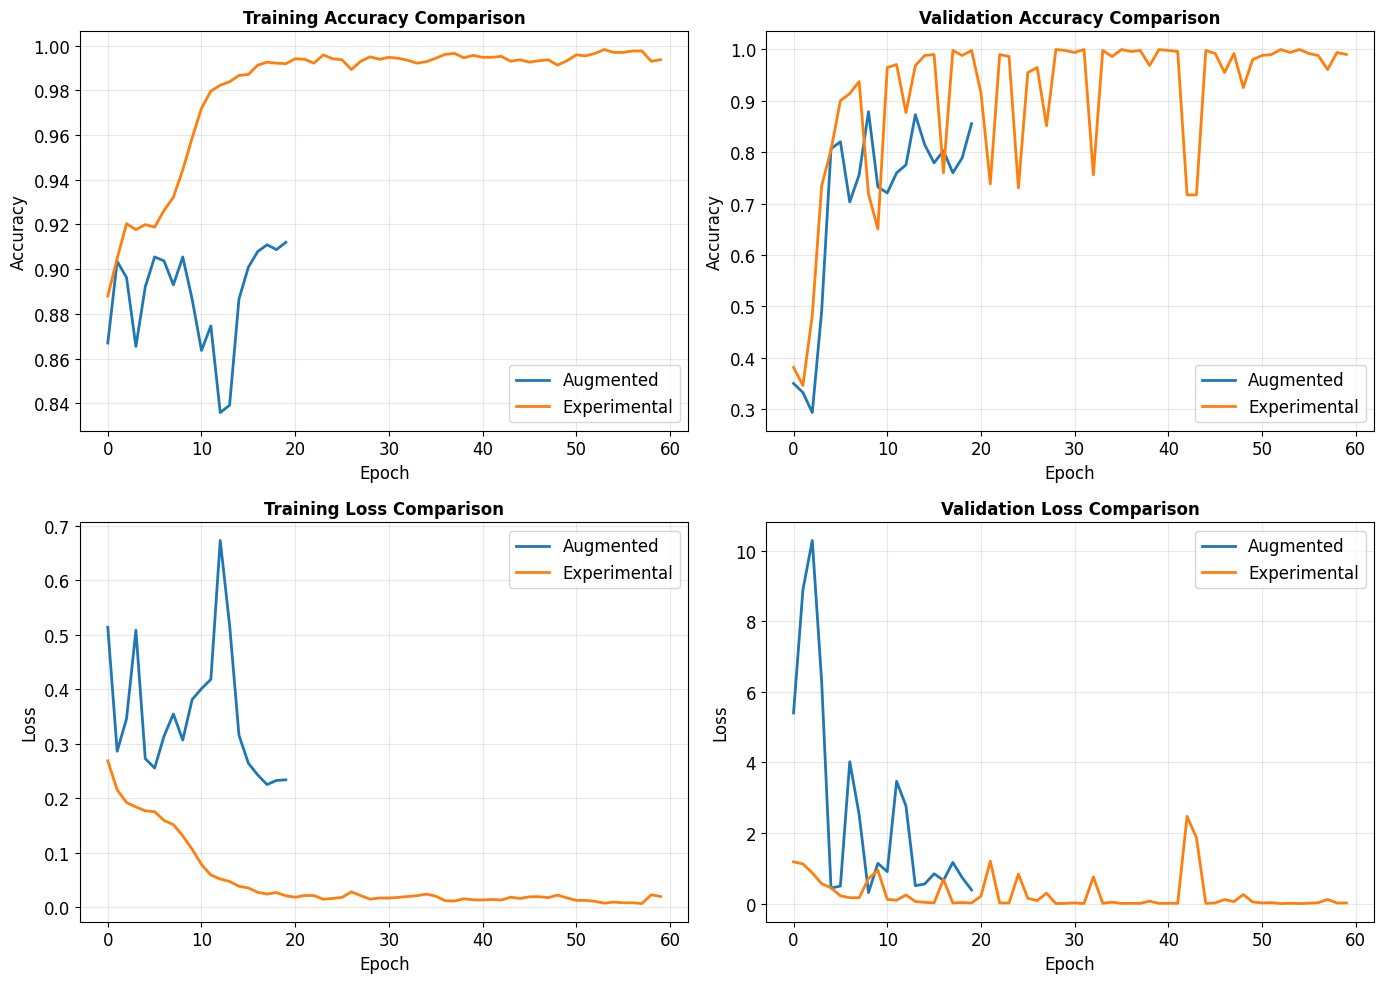

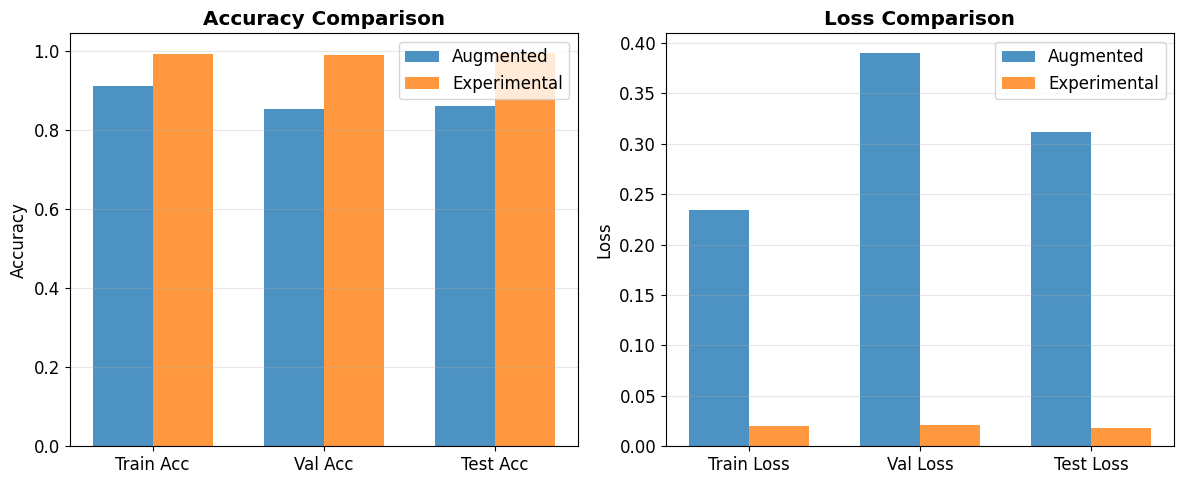

In [ ]:
# Compare augmented model to experimental model

# Evaluate experimental model on test set
test_loss_exp, test_acc_exp = model_experimental.evaluate(test_ds, verbose=0)

# Calculate F1 scores
f1_exp = f1_score(test_labels_list, test_predictions_exp, average='weighted')

# Calculate train-val gaps
train_val_gap_exp = history_experimental.history['accuracy'][-1] - history_experimental.history['val_accuracy'][-1]

# Create comprehensive comparison table (Augmented vs Experimental)
comparison_aug_exp = pd.DataFrame({
    'Metric': [
        'Final Train Accuracy',
        'Final Val Accuracy',
        'Test Accuracy',
        'Train-Val Gap',
        'Test Loss'
    ],
    'Augmented': [
        f"{history_augmented.history['accuracy'][-1]:.4f}",
        f"{history_augmented.history['val_accuracy'][-1]:.4f}",
        f"{test_acc_aug:.4f}",
        f"{train_val_gap_aug:.4f}",
        f"{test_loss_aug:.4f}"
    ],
    'Experimental': [
        f"{history_experimental.history['accuracy'][-1]:.4f}",
        f"{history_experimental.history['val_accuracy'][-1]:.4f}",
        f"{test_acc_exp:.4f}",
        f"{train_val_gap_exp:.4f}",
        f"{test_loss_exp:.4f}"
    ],
    'Improvement': [
        f"{(float(history_experimental.history['accuracy'][-1]) - float(history_augmented.history['accuracy'][-1])):.4f}",
        f"{(float(history_experimental.history['val_accuracy'][-1]) - float(history_augmented.history['val_accuracy'][-1])):.4f}",
        f"{(test_acc_exp - test_acc_aug):.4f}",
        f"{(train_val_gap_exp - train_val_gap_aug):.4f}",
        f"{(test_loss_exp - test_loss_aug):.4f}"
    ]
})

print("\n" + "="*90)
print("📊 AUGMENTED vs EXPERIMENTAL MODEL COMPARISON")
print("="*90)
print(comparison_aug_exp.to_string(index=False))
print("="*90)

# Plot comparison: Augmented vs Experimental
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Training accuracy comparison
axes[0, 0].plot(history_augmented.history['accuracy'], label='Augmented', linewidth=2)
axes[0, 0].plot(history_experimental.history['accuracy'], label='Experimental', linewidth=2)
axes[0, 0].set_title('Training Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Validation accuracy comparison
axes[0, 1].plot(history_augmented.history['val_accuracy'], label='Augmented', linewidth=2)
axes[0, 1].plot(history_experimental.history['val_accuracy'], label='Experimental', linewidth=2)
axes[0, 1].set_title('Validation Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Training loss comparison
axes[1, 0].plot(history_augmented.history['loss'], label='Augmented', linewidth=2)
axes[1, 0].plot(history_experimental.history['loss'], label='Experimental', linewidth=2)
axes[1, 0].set_title('Training Loss Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Validation loss comparison
axes[1, 1].plot(history_augmented.history['val_loss'], label='Augmented', linewidth=2)
axes[1, 1].plot(history_experimental.history['val_loss'], label='Experimental', linewidth=2)
axes[1, 1].set_title('Validation Loss Comparison', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Bar chart for final metrics
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

metrics = ['Train Acc', 'Val Acc', 'Test Acc']
augmented_scores = [
    history_augmented.history['accuracy'][-1],
    history_augmented.history['val_accuracy'][-1],
    test_acc_aug
]
experimental_scores = [
    history_experimental.history['accuracy'][-1],
    history_experimental.history['val_accuracy'][-1],
    test_acc_exp
]

x = np.arange(len(metrics))
width = 0.35

ax[0].bar(x - width/2, augmented_scores, width, label='Augmented', alpha=0.8)
ax[0].bar(x + width/2, experimental_scores, width, label='Experimental', alpha=0.8)
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy Comparison', fontweight='bold')
ax[0].set_xticks(x)
ax[0].set_xticklabels(metrics)
ax[0].legend()
ax[0].grid(True, alpha=0.3, axis='y')

loss_metrics = ['Train Loss', 'Val Loss', 'Test Loss']
augmented_losses = [
    history_augmented.history['loss'][-1],
    history_augmented.history['val_loss'][-1],
    test_loss_aug
]
experimental_losses = [
    history_experimental.history['loss'][-1],
    history_experimental.history['val_loss'][-1],
    test_loss_exp
]

ax[1].bar(x - width/2, augmented_losses, width, label='Augmented', alpha=0.8)
ax[1].bar(x + width/2, experimental_losses, width, label='Experimental', alpha=0.8)
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss Comparison', fontweight='bold')
ax[1].set_xticks(x)
ax[1].set_xticklabels(loss_metrics)
ax[1].legend()
ax[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Feature maps

  conv2d: output shape = (None, 62, 62, 32)
  conv2d_1: output shape = (None, 29, 29, 64)
  conv2d_2: output shape = (None, 12, 12, 128)
Class mapping: ['cloudy', 'desert', 'green_area', 'water']


2026-02-17 10:15:09.807994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


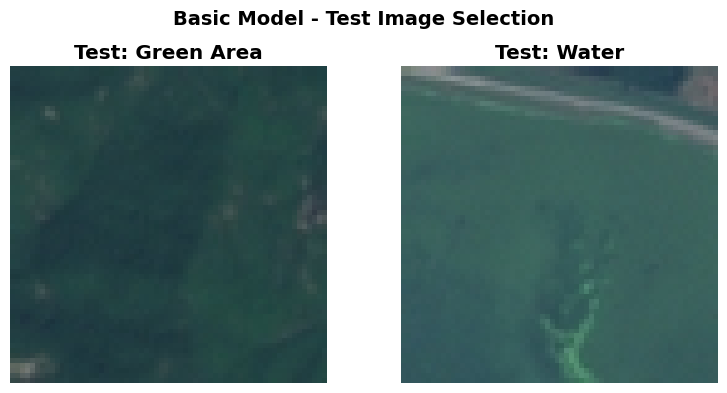

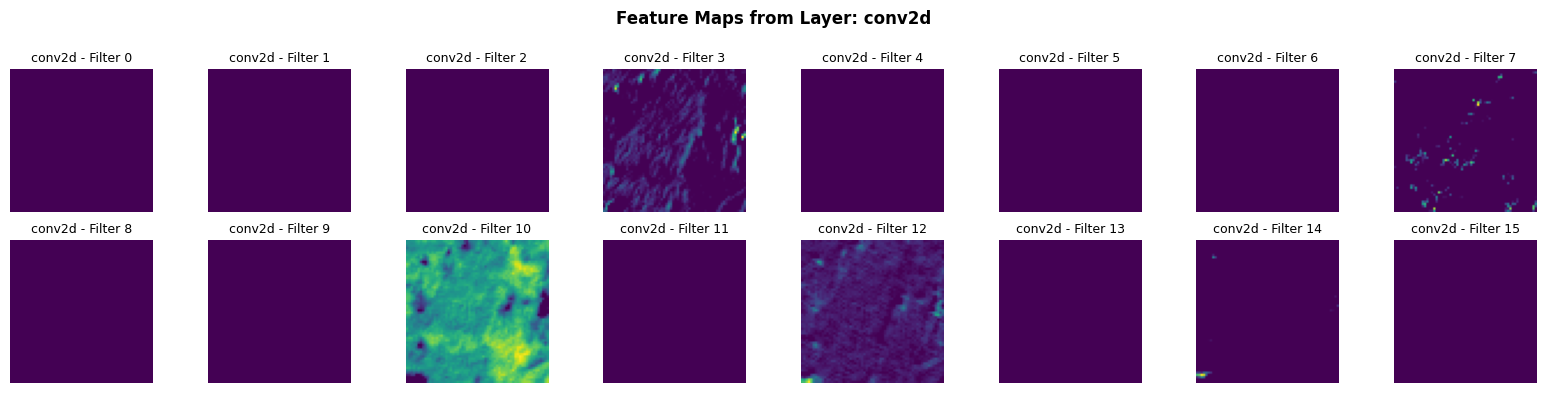

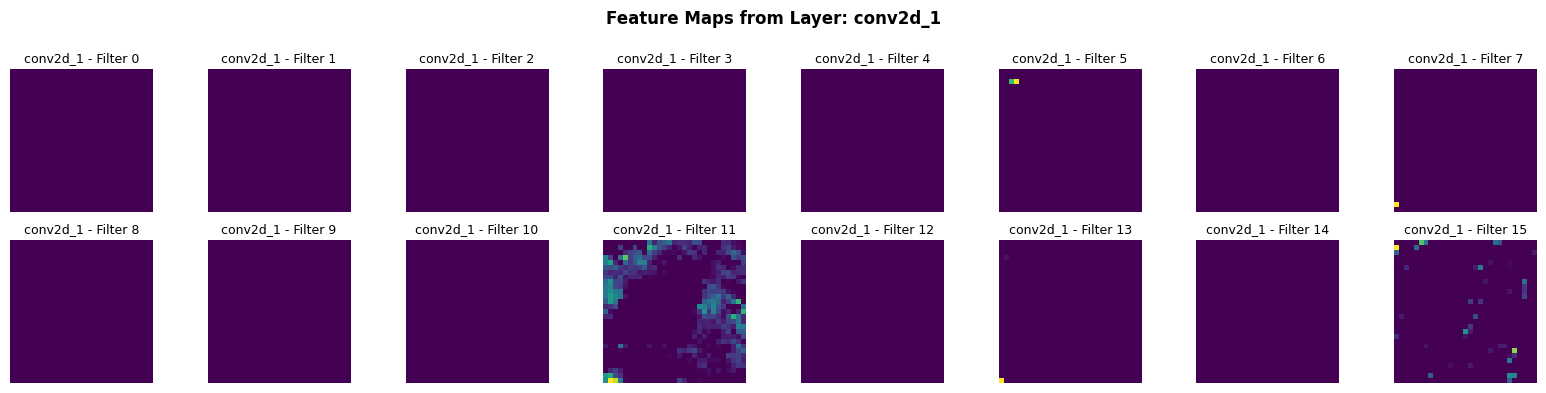

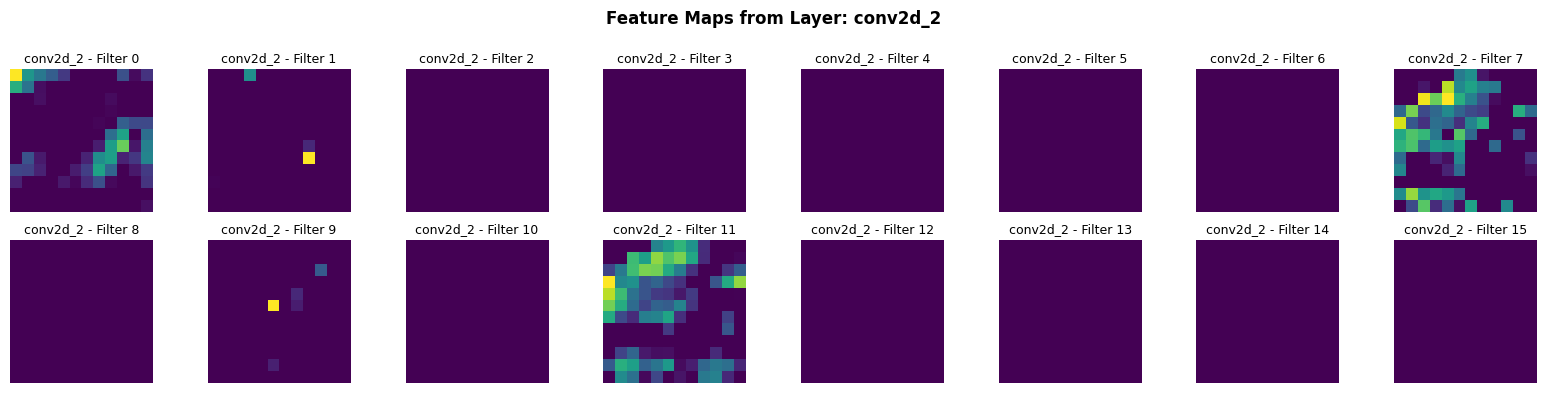

  conv2d_3: output shape = (None, 62, 62, 32)
  conv2d_4: output shape = (None, 29, 29, 64)
  conv2d_5: output shape = (None, 12, 12, 128)
Class mapping: ['cloudy', 'desert', 'green_area', 'water']


2026-02-17 10:15:10.734685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


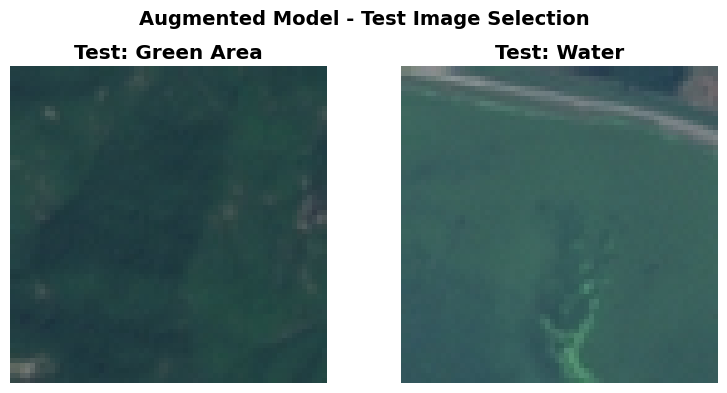

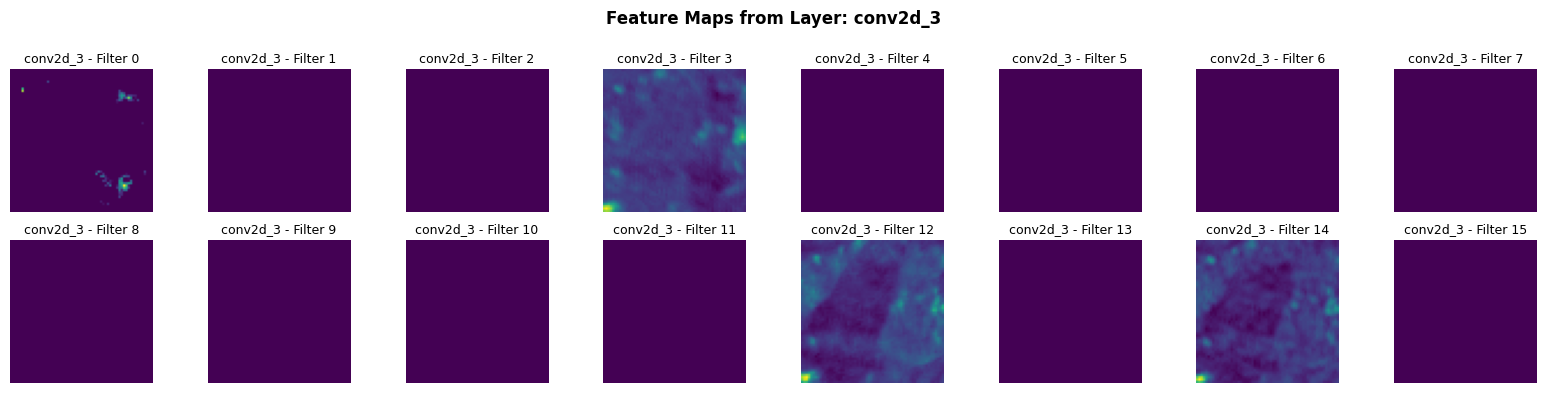

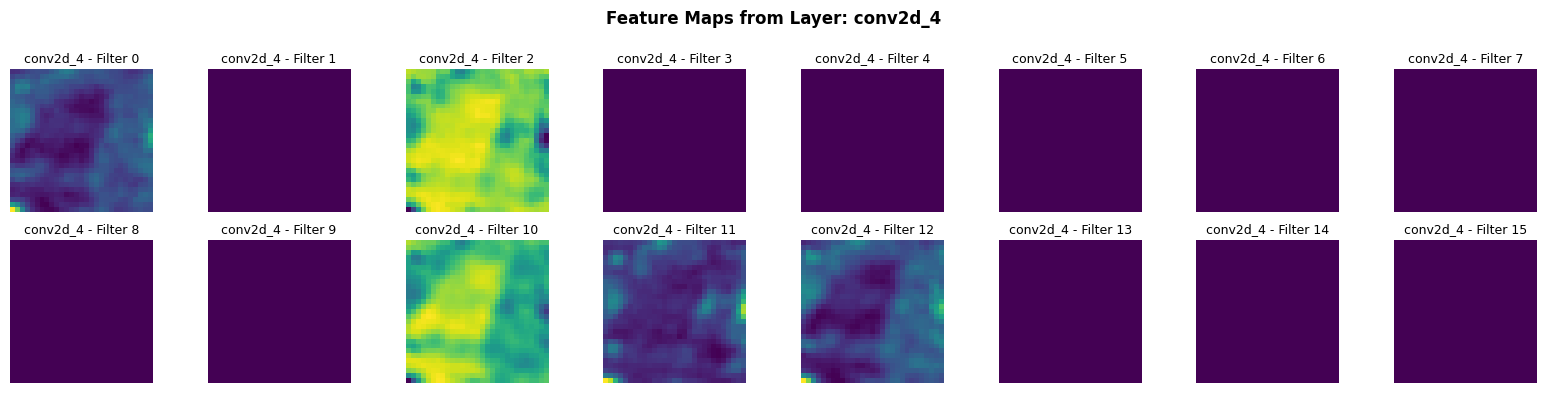

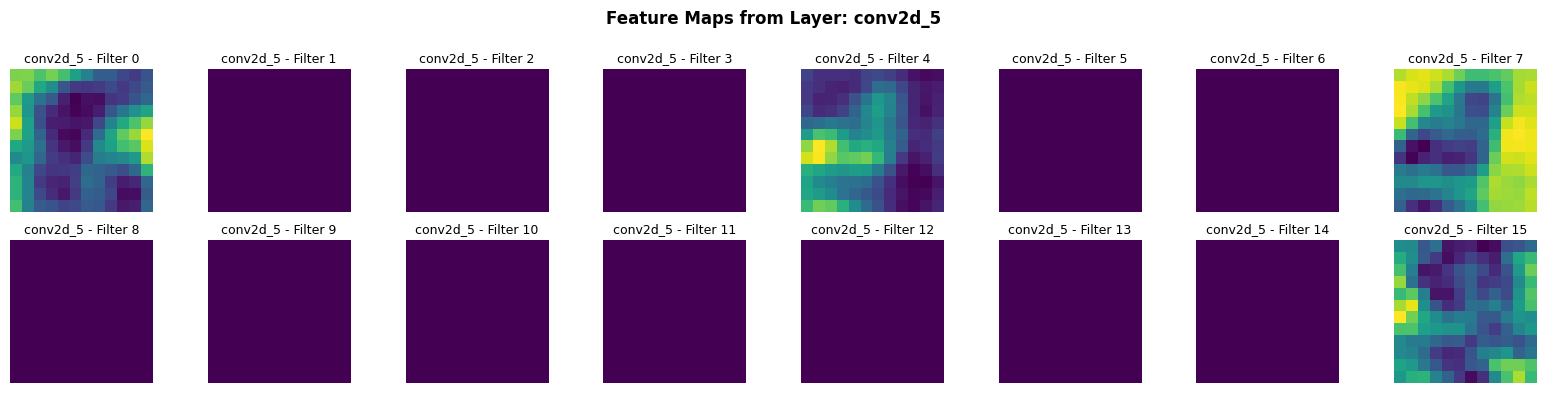

  conv2d_53: output shape = (None, 62, 62, 32)
  conv2d_54: output shape = (None, 60, 60, 32)
  conv2d_55: output shape = (None, 28, 28, 64)
  conv2d_56: output shape = (None, 26, 26, 64)
Class mapping: ['cloudy', 'desert', 'green_area', 'water']


2026-02-17 10:15:11.502081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


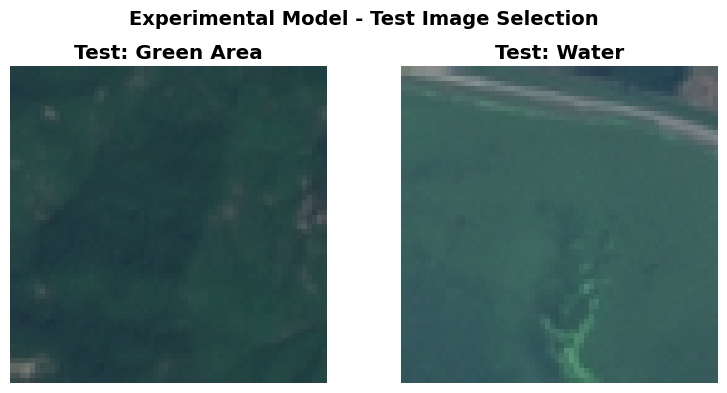

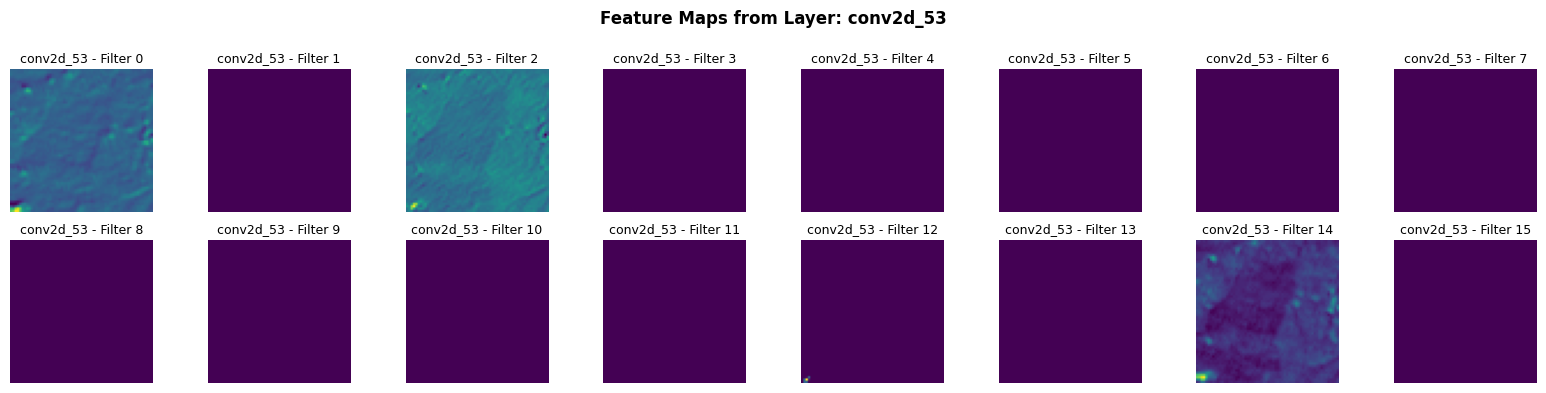

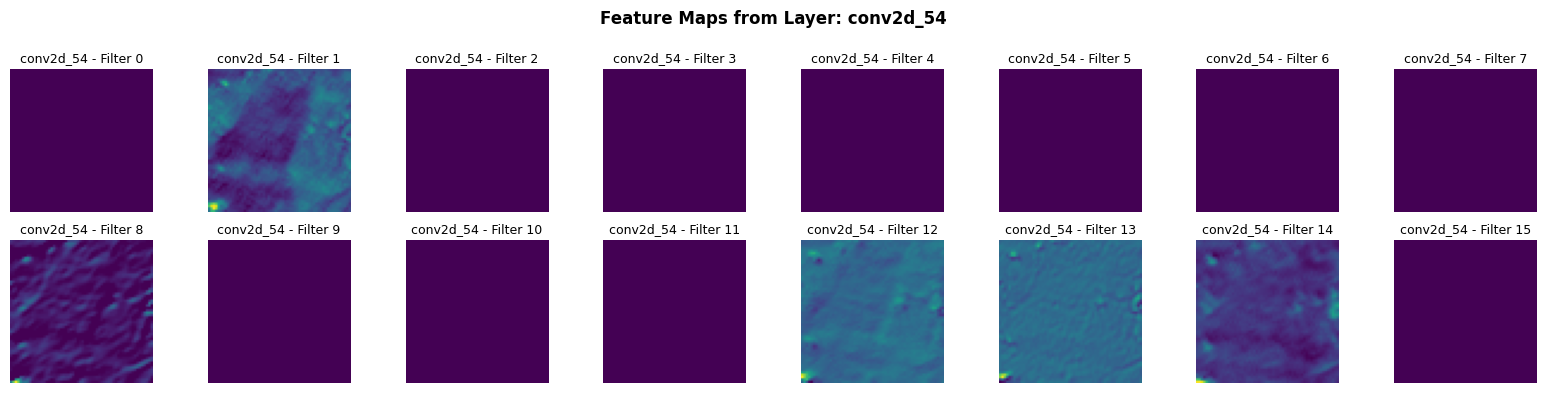

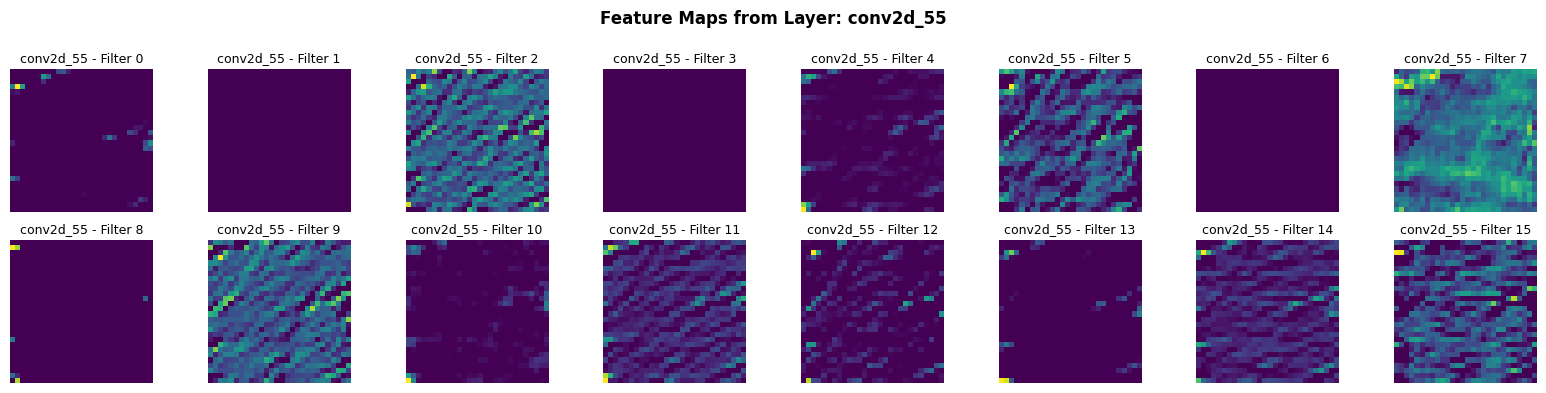

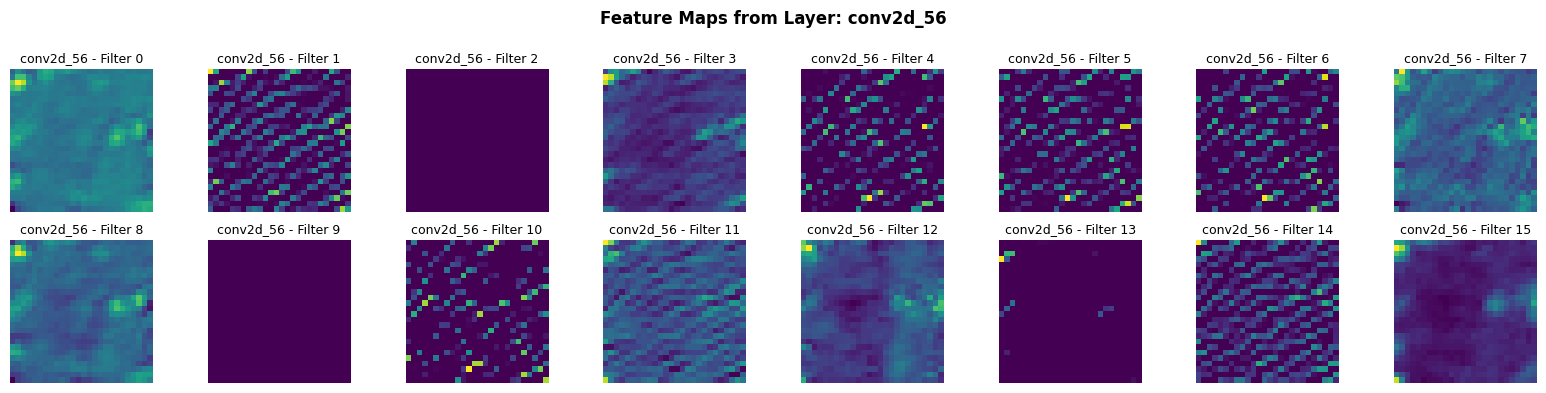

In [ ]:
inp = keras.Input(shape=(64, 64, 3))

for model_name, model in [("Basic", model_basic), ("Augmented", model_augmented), ("Experimental", model_experimental)]:
    x = inp
    conv_outputs = []
    conv_names = []
    for layer in model.layers:
        x = layer(x)
        if isinstance(layer, layers.Conv2D):
            conv_outputs.append(x)
            conv_names.append(layer.name)
            print(f"  {layer.name}: output shape = {x.shape}")

    feature_map_model = models.Model(inputs=inp, outputs=conv_outputs)

    print(f"Class mapping: {class_names}")

    green_area_class = class_names.index('green_area') if 'green_area' in class_names else 0
    water_class = class_names.index('water') if 'water' in class_names else 0

    for images, labels_batch in val_ds.take(1):
        green_area_idx = None
        water_idx = None
        for i in range(len(labels_batch)):
            label = int(labels_batch[i].numpy())
            if label == green_area_class and green_area_idx is None:
                green_area_idx = i
            elif label == water_class and water_idx is None:
                water_idx = i
            if green_area_idx is not None and water_idx is not None:
                break

        test_green_area = images[green_area_idx]
        test_water = images[water_idx]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(test_green_area.numpy().astype('uint8'))
    ax1.set_title('Test: Green Area', fontweight='bold')
    ax1.axis('off')
    ax2.imshow(test_water.numpy().astype('uint8'))
    ax2.set_title('Test: Water', fontweight='bold')
    ax2.axis('off')
    plt.suptitle(f"{model_name} Model - Test Image Selection", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    test_input = tf.expand_dims(test_green_area, 0)
    feature_maps = feature_map_model.predict(test_input, verbose=0)

    # conv_names was defined in the cell above

    for layer_idx, feature_map in enumerate(feature_maps):
        num_filters = feature_map.shape[-1]
        plt.figure(figsize=(16, 4))
        for i in range(min(16, num_filters)):
            plt.subplot(2, 8, i + 1)
            plt.imshow(feature_map[0, :, :, i], cmap='viridis')
            plt.title(f'{conv_names[layer_idx]} - Filter {i}', fontsize=9)
            plt.axis('off')
        plt.suptitle(f'Feature Maps from Layer: {conv_names[layer_idx]}', fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()